In [3]:
import markhov
import em
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Demonstrating EM

Here we demonstrate the use and behaviour of the various functions in our expectation maximisation algorithm for learning rule probagbilities for a two-part grammar made up of a finite state automaton that generates strings of operations and a bigram grammar of legal transitions for the operation Merge.

### Get set up

Some functions for log-transforming the grammar

In [4]:
def ops_log(ops):
    for a in ops:
        for b in ops[a]:
            for w in ops[a][b]:
                ops[a][b][w]=np.log(ops[a][b][w])
    return ops

def bis_log(bigrams):
    for a in bigrams:
        for b in bigrams[a]:
            bigrams[a][b]=np.log(bigrams[a][b])
    return bigrams


Make some transitions

In [5]:
trans = {'a':['a','b'],
           'b':['b','a'],
           '[':['a','b']
       }


In [6]:
trans_probs = {'a':{'a':0.5,'b':0.5},
           'b':{'b':0.5,'a':0.5},
           '[':{'a':0.5,'b':0.5}
       }

trans_probs=bis_log(trans_probs)

Operations FSA

In [7]:
ops = {'S':{'NotCL':['mg']}, # from start we have to merge
       'NotCL':{'NotCL':['mg','copy'], # this state is the state in which the last "special" operation was *not* Clear. 
                #Either we've done none or the last was copy. From here we can do everything including end
               'CLEAR_S':['clear'], # go here to clear the buffer
               'F':['end'] # go here to end
           },
       'CLEAR_S':{'CLEAR':['mg']}, # this is where we've just cleared. Buffer is empty so you can only Merge
       'CLEAR':{'CLEAR':['mg'], # the last special op was Clear so we can Copy or Merge.
                'NotCL':['copy'] # if we Copy, the last special op was Copy so go to NotCL
            },
       'F':{} #final state
   }


In [8]:
ops_probs = {'S':{'NotCL':{'mg':1.}}, # from start we have to merge
       'NotCL':{'NotCL':{'mg':0.3,'copy':0.1}, # this state is the state in which the last "special" operation was *not* Clear. 
                #Either we've done none or the last was copy. From here we can do everything including end
               'CLEAR_S':{'clear':0.1}, # go here to clear the buffer
               'F':{'end':0.5} # go here to end
           },
       'CLEAR_S':{'CLEAR':{'mg':1.}}, # this is where we've just cleared. Buffer is empty so you can only Merge
       'CLEAR':{'CLEAR':{'mg':0.5}, # the last special op was Clear so we can Copy or Merge.
                'NotCL':{'copy':0.5} # if we Copy, the last special op was Copy so go to NotCL
            },
       'F':{} #final state
   }

ops_probs=ops_log(ops_probs)

A corpus

In [9]:
aaa = ['a','a a','a a a']

### Parse a sentence

In [10]:
s=aaa[-1]

In [11]:
parses=markhov.parse(s,trans,ops)

In [12]:
for i in range(len(parses)):
    print(markhov.parse2string(parses[i]))


bigrams: [ a a a
buffer: a a a
op states: S NotCL NotCL NotCL F
operations: mg mg mg end
k: 3

bigrams: [ a a
buffer: a a a
op states: S NotCL NotCL NotCL F
operations: mg copy mg end
k: 3

bigrams: [ a a
buffer: a a
op states: S NotCL CLEAR_S CLEAR NotCL F
operations: mg clear mg copy end
k: 3


### Parse the corpus

In [13]:
parsed_corpus=em.parse_corpus(aaa,trans,ops)

In [14]:
print(em.parsed_corpus2string(parsed_corpus))


Parse 0:
Sentence: a
bigrams: [ a
Q: S NotCL F
E: mg end
SC:
  S 1
  F 1
  NotCL 1
TC:
  NotCL end F 1
  S mg NotCL 1
UC:
  [ 1
BC:
  [ a 1

Parse 1:
Sentence: a a
bigrams: [ a a
Q: S NotCL NotCL F
E: mg mg end
SC:
  S 1
  F 1
  NotCL 2
TC:
  NotCL mg NotCL 1
  NotCL end F 1
  S mg NotCL 1
UC:
  a 1
  [ 1
BC:
  [ a 1
  a a 1

Parse 2:
Sentence: a a
bigrams: [ a
Q: S NotCL NotCL F
E: mg copy end
SC:
  S 1
  F 1
  NotCL 2
TC:
  NotCL copy NotCL 1
  NotCL end F 1
  S mg NotCL 1
UC:
  [ 1
BC:
  [ a 1

Parse 3:
Sentence: a a a
bigrams: [ a a a
Q: S NotCL NotCL NotCL F
E: mg mg mg end
SC:
  S 1
  F 1
  NotCL 3
TC:
  NotCL mg NotCL 2
  NotCL end F 1
  S mg NotCL 1
UC:
  a 2
  [ 1
BC:
  [ a 1
  a a 2

Parse 4:
Sentence: a a a
bigrams: [ a a
Q: S NotCL NotCL NotCL F
E: mg copy mg end
SC:
  S 1
  F 1
  NotCL 3
TC:
  NotCL copy NotCL 1
  NotCL mg NotCL 1
  NotCL end F 1
  S mg NotCL 1
UC:
  a 1
  [ 1
BC:
  [ a 1
  a a 1

Parse 5:
Sentence: a a a
bigrams: [ a a
Q: S NotCL CLEAR_S CLEAR NotCL F
E:

Make a parallel list of parse relative probabilities

In [15]:
parse_probs=em.get_p_parses(parsed_corpus,ops_probs,trans_probs)

In [16]:
print(parse_probs)

[1.0, 0.59999999999999987, 0.39999999999999997, 0.36000000000000015, 0.24000000000000005, 0.40000000000000036]


In [17]:
(exp_unigrams,exp_bigrams) = em.expected_counts_trans(parsed_corpus,parse_probs,trans)

In [18]:
for u in exp_unigrams:
    print '\nExpected count of %s in each sentence:'%u
    for s in exp_unigrams[u]:
        print (' %s: %.4f'%(s,exp_unigrams[u][s]))


Expected count of a in each sentence:
 a: 0.0000
 a a: 0.6000
 a a a: 1.3600

Expected count of [ in each sentence:
 a: 1.0000
 a a: 1.0000
 a a a: 1.0000

Expected count of b in each sentence:
 a: 0.0000
 a a: 0.0000
 a a a: 0.0000


In [19]:
for a in exp_bigrams:
    for b in exp_bigrams[a]:
        print '\nExpected count of %s %s in each sentence:'%(a,b)
        for s in exp_bigrams[a][b]:
            print (' %s: %.4f'%(s,exp_bigrams[a][b][s]))


Expected count of a a in each sentence:
 a: 0.0000
 a a: 0.6000
 a a a: 1.3600

Expected count of a b in each sentence:
 a: 0.0000
 a a: 0.0000
 a a a: 0.0000

Expected count of [ a in each sentence:
 a: 1.0000
 a a: 1.0000
 a a a: 1.0000

Expected count of [ b in each sentence:
 a: 0.0000
 a a: 0.0000
 a a a: 0.0000

Expected count of b a in each sentence:
 a: 0.0000
 a a: 0.0000
 a a a: 0.0000

Expected count of b b in each sentence:
 a: 0.0000
 a a: 0.0000
 a a a: 0.0000


In [20]:
(exp_states,exp_tr) = em.expected_counts_fsa(parsed_corpus,parse_probs,ops)

In [21]:
for u in exp_states:
    print '\nExpected count of %s in each sentence:'%u
    for s in exp_states[u]:
        print (' %s: %.4f'%(s,exp_states[u][s]))


Expected count of S in each sentence:
 a: 1.0000
 a a: 1.0000
 a a a: 1.0000

Expected count of NotCL in each sentence:
 a: 1.0000
 a a: 2.0000
 a a a: 2.6000

Expected count of CLEAR_S in each sentence:
 a: 0.0000
 a a: 0.0000
 a a a: 0.4000

Expected count of CLEAR in each sentence:
 a: 0.0000
 a a: 0.0000
 a a a: 0.4000

Expected count of F in each sentence:
 a: 1.0000
 a a: 1.0000
 a a a: 1.0000


In [22]:
for a in exp_tr:
    for b in exp_tr[a]:
        for e in exp_tr[a][b]:
            print '\nExpected count of (%s %s %s) in each sentence:'%(a,e,b)
            for s in exp_tr[a][b][e]:
                print (' %s: %.4f'%(s,exp_tr[a][b][e][s]))


Expected count of (S mg NotCL) in each sentence:
 a: 1.0000
 a a: 1.0000
 a a a: 1.0000

Expected count of (NotCL clear CLEAR_S) in each sentence:
 a: 0.0000
 a a: 0.0000
 a a a: 0.4000

Expected count of (NotCL mg NotCL) in each sentence:
 a: 0.0000
 a a: 0.6000
 a a a: 0.9600

Expected count of (NotCL copy NotCL) in each sentence:
 a: 0.0000
 a a: 0.4000
 a a a: 0.2400

Expected count of (NotCL end F) in each sentence:
 a: 1.0000
 a a: 1.0000
 a a a: 1.0000

Expected count of (CLEAR_S mg CLEAR) in each sentence:
 a: 0.0000
 a a: 0.0000
 a a a: 0.4000

Expected count of (CLEAR mg CLEAR) in each sentence:
 a: 0.0000
 a a: 0.0000
 a a a: 0.0000

Expected count of (CLEAR copy NotCL) in each sentence:
 a: 0.0000
 a a: 0.0000
 a a a: 0.4000


In [23]:
new_ops = em.update_rabbit_fsa(exp_states,exp_tr,ops)

In [24]:
print (markhov.fsa2string(new_ops,False)) # False prints the non-log probs



S
   NotCL
      mg	1.00

NotCL
   CLEAR_S
      clear	0.07
   NotCL
      mg	0.28
      copy	0.11
   F
      end	0.54

CLEAR_S
   CLEAR
      mg	1.00

CLEAR
   CLEAR
      mg	0.00
   NotCL
      copy	1.00

F


In [25]:
em.check_fsa(new_ops) # is this a valid probability distribution?

True

In [26]:
new_trans = em.update_rabbit_trans(exp_unigrams,exp_bigrams,trans)

In [27]:
print (markhov.trans2string(new_trans))



a
  a	0.00
  b	-inf

[
  a	0.00
  b	-inf

b
  a	-0.69
  b	-0.69


In [28]:
em.check_bis(new_trans) # check this is a valid probability distribution

True

## Expectation Maximisation time!

In [53]:
n = 50 # number of EM iterations to do

In [54]:
history=em.em_rabbit(aaa,trans,ops,n) # run EM

In [55]:
#for i,step in enumerate(history):
#    print ('\n--------\n--------\nIteration %i'%i)
#    print ('FSA:')
#    print (markhov.fsa2string(step['fsa']))
#    print ('\n------\nTrans probs:')
#    print (markhov.trans2string(step['trans_probs']))

Display the results

In [56]:
import pandas as pd

Make the rules into a simpler list

In [57]:
rules=[]
for lhs in ops:
    for rhs in ops[lhs]:
        for e in ops[lhs][rhs]:
            rules.append(('%s->%s %s'%(lhs,e,rhs),(lhs,rhs,e)))

Put them and their updating probabilities into a table

In [58]:
tab=[]
for (rule,(lhs,rhs,e)) in rules:
    thisrule={'rule':rule}
    for i in range(n):
        p=history[i]['fsa'][lhs][rhs][e]
        thisrule["p.iteration%03d"%i]=p
    tab.append(thisrule)

Use pandas to make the table into a datafram

In [59]:
df = pd.DataFrame(tab)

In [60]:
df

,p.iteration000,p.iteration001,p.iteration002,p.iteration003,p.iteration004,p.iteration005,p.iteration006,p.iteration007,p.iteration008,p.iteration009,...,p.iteration041,p.iteration042,p.iteration043,p.iteration044,p.iteration045,p.iteration046,p.iteration047,p.iteration048,p.iteration049,rule
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,S->mg NotCL
1,-0.103666,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,CLEAR->mg CLEAR
2,-2.317964,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,CLEAR->copy NotCL
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,CLEAR_S->mg CLEAR
4,-1.533047,-2.949170,-2.403479,-2.216665,-2.162743,-2.175683,-2.231219,-2.320419,-2.440960,-2.593459,...,-14.588367,-14.993831,-15.399295,-15.804759,-16.210224,-16.615689,-17.021154,-17.426619,-17.832084,NotCL->clear CLEAR_S
5,-1.411498,-0.642090,-0.606600,-0.589714,-0.584285,-0.585611,-0.591135,-0.599445,-0.609655,-0.621049,...,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,NotCL->end F
6,-2.146648,-2.074845,-1.756208,-1.612424,-1.501037,-1.396663,-1.296147,-1.200555,-1.111436,-1.030214,...,-0.693149,-0.693148,-0.693148,-0.693148,-0.693148,-0.693147,-0.693147,-0.693147,-0.693147,NotCL->mg NotCL
7,-0.859272,-1.217905,-1.651839,-1.986765,-2.257733,-2.497592,-2.728454,-2.963763,-3.211447,-3.476098,...,-15.921468,-16.326932,-16.732397,-17.137862,-17.543326,-17.948791,-18.354256,-18.759721,-19.165186,NotCL->copy NotCL


In [61]:
df.to_csv('ops_%s.csv'%('oct_22_2016_aaa')) # print to file

Same for the transitions

In [62]:
bigrams=[]
for lhs in trans:
    for rhs in trans[lhs]:
        bigrams.append(('%s,%s'%(lhs,rhs),(lhs,rhs)))

In [63]:
bigrams

[('a,a', ('a', 'a')),
 ('a,b', ('a', 'b')),
 ('[,a', ('[', 'a')),
 ('[,b', ('[', 'b')),
 ('b,b', ('b', 'b')),
 ('b,a', ('b', 'a'))]

In [64]:
tab=[]
for (bi,(lhs,rhs)) in bigrams:
    thisrule={'rule':bi}
    for i in range(n):
        p=history[i]['trans_probs'][lhs][rhs]
        thisrule["p.iteration%i"%i]=p
    tab.append(thisrule)

In [65]:
df_bis = pd.DataFrame(tab)

In [66]:
df_bis

,p.iteration0,p.iteration1,p.iteration10,p.iteration11,p.iteration12,p.iteration13,p.iteration14,p.iteration15,p.iteration16,p.iteration17,...,p.iteration46,p.iteration47,p.iteration48,p.iteration49,p.iteration5,p.iteration6,p.iteration7,p.iteration8,p.iteration9,rule
0,-3.461732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"a,a"
1,-0.031878,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,"a,b"
2,-0.270596,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[,a"
3,-1.439378,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,"[,b"
4,-1.276119,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,...,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,"b,b"
5,-0.327281,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,...,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,"b,a"


In [67]:
df_bis.to_csv('trans_%s.csv'%('oct_22_2016_aaa'))

### Calculate the log likelihood of the corpus given the trained grammar

This is the ll of the corpus at the end of training:

In [68]:
markhov.ll_corpus(parsed_corpus,history[-1]['trans_probs'],history[-1]['fsa'])

-4.1588831137120508

Make a dataframe of the LL of the corpus throughout training:

In [69]:
tab=[]
for i in range(n):
    this_iter={'iteration':i,
               'likelihood':markhov.ll_corpus(parsed_corpus,history[i]['trans_probs'],history[i]['fsa'])}
    tab.append(this_iter)

In [70]:
df_lls=pd.DataFrame(tab)

In [71]:
df_lls

,iteration,likelihood
0,0,-12.001208
1,1,-5.041286
2,2,-4.704455
3,3,-4.594992
4,4,-4.540447
5,5,-4.500605
6,6,-4.464301
7,7,-4.428336
8,8,-4.392044
9,9,-4.355788


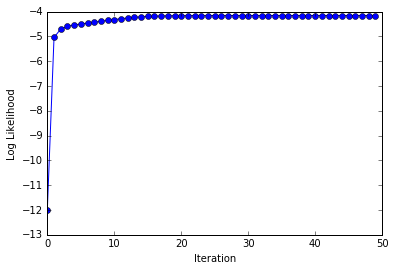

In [72]:
plot(df_lls["iteration"],df_lls["likelihood"],'o-')
xlabel("Iteration")
ylabel("Log Likelihood")

In [73]:
tab=[]

for i,(s,parse) in enumerate(parsed_corpus):
    this_parse={'sentence':' '.join(s),'bigrams':' '.join(parse['bis']),'Q':' '.join(parse['rt'][0]),'E':' '.join(parse['rt'][1])}
    for iter in range(1,n):
        this_parse['iteration_%i p'%iter]=history[iter]['parse_ps'][i]
    tab.append(this_parse)

In [74]:
df.parses=pd.DataFrame(tab)


In [75]:
df.parses


,E,Q,bigrams,iteration_1 p,iteration_10 p,iteration_11 p,iteration_12 p,iteration_13 p,iteration_14 p,iteration_15 p,...,iteration_46 p,iteration_47 p,iteration_48 p,iteration_49 p,iteration_5 p,iteration_6 p,iteration_7 p,iteration_8 p,iteration_9 p,sentence
0,mg end,S NotCL F,[ a,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,a
1,mg mg end,S NotCL NotCL F,[ a a,0.008585,0.920260,0.942785,0.959625,0.971909,0.980679,0.986829,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.680636,0.750434,0.807261,0.853611,0.890904,a a
2,mg copy end,S NotCL NotCL F,[ a,0.991415,0.079740,0.057215,0.040375,0.028091,0.019321,0.013171,...,4.809061e-08,3.206041e-08,2.137361e-08,1.424907e-08,0.319364,0.249566,0.192739,0.146389,0.109096,a a
3,mg mg mg end,S NotCL NotCL NotCL F,[ a a a,0.006021,0.597560,0.674543,0.745771,0.807884,0.859067,0.899163,...,9.999996e-01,9.999997e-01,9.999998e-01,9.999999e-01,0.264268,0.313763,0.374023,0.443355,0.519073,a a a
4,mg copy mg end,S NotCL NotCL NotCL F,[ a a,0.695325,0.051778,0.040936,0.031378,0.023350,0.016925,0.012001,...,4.809059e-08,3.206040e-08,2.137360e-08,1.424907e-08,0.123998,0.104346,0.089301,0.076033,0.063563,a a a
5,mg clear mg copy end,S NotCL CLEAR_S CLEAR NotCL F,[ a a,0.298654,0.350662,0.284521,0.222851,0.168766,0.124008,0.088837,...,3.647953e-07,2.431970e-07,1.621313e-07,1.080876e-07,0.611733,0.581891,0.536676,0.480613,0.417363,a a a


In [76]:
reload(markhov)

<module 'markhov' from 'markhov.pyc'>